In [1]:
import os
import glob
from nansat import *
from scipy.ndimage.filters import gaussian_filter, median_filter
from matplotlib.colors import LogNorm
from scipy.ndimage.interpolation import rotate
from multiprocessing import Pool
from matplotlib.patches import Polygon

from ovl_plugins.fusion.fusion import fuse

In [20]:
# sentinel_data_root = os.path.join('~', 'Documents', 'Work', 'sentinel2a_data')
# Sentinel 2a image data path
ifile = '/nfs0/data_ocolor/michigan/sentinel2a/S2A_OPER_PRD_MSIL1C_PDMC_20160904T205606_R126_V20160903T164322_20160903T164911.SAFE'
modis_file = '/'
sbd_granules = [
    '16TER', '16TFR',
    '16TEQ', '16TFQ'
]

pixel_size = 60 # pixel size in m
x_resol, y_resol = 122 * (1000 / 60), 78 * (1000 / 60) # size in km
sbd_dom = Domain('+proj=latlong +datum=WGS84 +ellps=WGS84 +no_defs', '-lle -86.3 44.6 -85.2 45.3 -ts %i %i' % (x_resol, y_resol))

=>michigan.grd<=


/data0/home/artemm/miniconda/envs/niersc/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


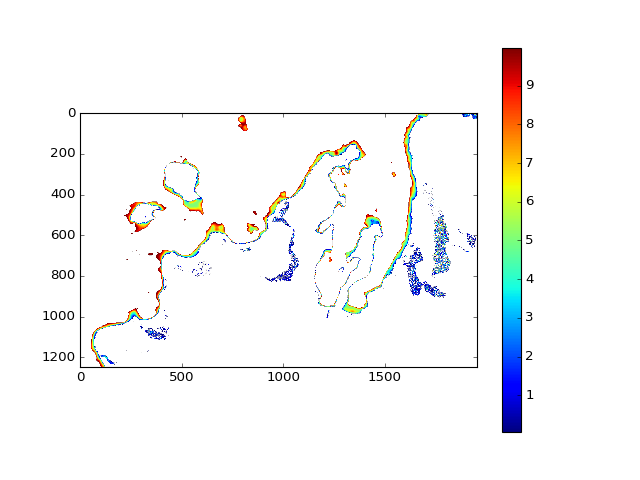

In [4]:
%matplotlib nbagg

bathymetry = Nansat(os.path.join('data', 'michigan_lld.grd'))
bathymetry.reproject(sbd_dom)
h = bathymetry[1]
h = np.where(h >= 0, np.nan, h * -1)
h[h > 10] = np.nan
plt.figure()
plt.imshow(h)
plt.colorbar()
plt.show()

In [5]:
%matplotlib nbagg
n = Nansat('scripts/S2A_OPER_PRD_MSIL1C_PDMC_20160904T205606_R126_V20160903T164322_20160903T164911.SAFE_full.nc')
n.reproject(sbd_dom)
mask = ((n[1] > 0) * (n[1] < 1200)).astype('uint8')
f = Figure([n[4], n[3], n[1]], mask_array=mask, mask_lut={0:[255,255,255], 2:[128,128,128]})
clim = f.clim_from_histogram(ratio=0.95)
f.process(cmin=clim[0], cmax=clim[1], logarithm=True, gamma=3)
f.save('rgb.png')

10:12:51|40|nansat|_get_mapper|GDAL could not open scripts/S2A_OPER_PRD_MSIL1C_PDMC_20160904T205606_R126_V20160903T164322_20160903T164911.SAFE_full.nc, trying to read with Nansat mappers...
ERROR:Nansat:GDAL could not open scripts/S2A_OPER_PRD_MSIL1C_PDMC_20160904T205606_R126_V20160903T164322_20160903T164911.SAFE_full.nc, trying to read with Nansat mappers...


IOError: scripts/S2A_OPER_PRD_MSIL1C_PDMC_20160904T205606_R126_V20160903T164322_20160903T164911.SAFE_full.nc: File does not exist

In [45]:
# Create new geolocation for MODIS-a image
sfile = ifile # <ifile> is path to sentinel image
mfile = '/nfs0/data_ocolor/michigan/MODISa/A2016248183000.L2_LAC_OC.nc'
ofile = os.path.split(mfile)[1] + '_pro.nc'
# GCP_COUNT is frequncy of rows used for gettin coordinates array ? 
# Get MODIS-a image by nansat
n = Nansat(mfile, GCP_COUNT=40)
# Remove geolocation
n.vrt.remove_geolocationArray()
n.vrt.tps = True
n.reproject_GCPs()
print n.time_coverage_start

# add index of pixels
index = np.arange(0, n.shape()[0] * n.shape()[1]).reshape(n.shape()).astype('int32')
n.add_band(index, parameters={'name': 'index'})

n.reproject(sbd_dom, addmask=False)
#bands = ['Rrs_412', 'Rrs_443', 'Rrs_488', 'Rrs_531', 'Rrs_547', 'Rrs_555', 'Rrs_645', 'Rrs_667', 'Rrs_678', 'angstrom', 'aot_869', 'chlor_a']
#bands = ['Rrs_667', 'Rrs_555', 'Rrs_488', 'Rrs_443', 'Rrs_412']
bands = ['index', 'Rrs_667', 'Rrs_555', 'Rrs_488', 'Rrs_412', 'Rrs_443', 'Rrs_531', 'Rrs_645', 'Rrs_678']

nexp = Nansat(domain=sbd_dom)
for band in bands:
    print band,
    bandArray = n[band]
    print bandArray.dtype
    nexp.add_band(bandArray, parameters={'name': band})

nexp.export("output/hello.nc")

2016-09-04 18:30:10.654000+00:00
index int32
Rrs_667 float32
Rrs_555 float32
Rrs_488 float32
Rrs_412 float32
Rrs_443 float32
Rrs_531 float32
Rrs_645 float32
Rrs_678 float32


In [47]:
%matplotlib nbagg

sentinel_wavelenghts = [443, 490, 560, 665, 705, 740, 783, 842, 945, 1375, 1610]
modis_wavelenghts = [412, 443, 469, 488, 531, 547, 555, 645, 667, 678]   # All MODIS channels
modis_wavelenghts_1x1km_bands = [412, 443, 488, 531, 645, 678]
pixel_size = 60
x_resol, y_resol = 122 * (1000 / pixel_size), 78 * (1000 / pixel_size)
sbd_dom = Domain('+proj=latlong +datum=WGS84 +ellps=WGS84 +no_defs', '-lle -86.3 44.6 -85.2 45.3 -ts %s %s' % (x_resol, y_resol))


hiresfile = 'output/S2A_OPER_PRD_MSIL1C_PDMC_20160904T205606_R126_V20160903T164322_20160903T164911.SAFE_full.nc'
loresfile = 'output/hello.nc'


# TEST 1
bands = ['Rrs_667', 'Rrs_555', 'Rrs_488', 'Rrs_412', 'Rrs_443', 'Rrs_531', 'Rrs_645', 'Rrs_678']
pref = 'test01_'
smooth = False
skip = True
log = False
mask = True
cut = True


# load lo-res
nnn = Nansat(loresfile)
nnn.reproject(sbd_dom)
negpix = nnn[2] < 0
index = nnn['index']

# print(nnn)
# print(negpix.shape)
# plt.figure()
# plt.imshow(negpix)
# plt.show()

# load hi-res
# Load file with sentinel data
n_s = Nansat(hiresfile)
n_s.reproject(sbd_dom)
# Get numbers of of each band
band_rrs_numbers = [n_s._get_band_number('Rrs_%s' % wavelength) for wavelength in sentinel_wavelenghts] 
# Create array form 
hires = np.array([n_s[i] for i in band_rrs_numbers])
# hires = np.load(hiresfile)['arr_0'].astype(np.float64)

# remove out-of-swath
hires[:, hires[0]==0] = np.nan
    
bMax = 230 # OK
#bMax = 200 # MAYBE A BIT TOO LOW

# for noise corrected bands
bMin = -30
# bMax = 20 ???????

cutsize = 2000

if mask:
    # mask land and coastal zone
    wm = nnn.watermask()[1]
    wmgf = gaussian_filter(wm.astype(np.float32), 1)
    hires[:, wmgf > 1] = np.nan

    # mask clouds
    hires[:, hires[7] > bMax] = np.nan

    hires[:, hires[0] < bMin] = np.nan

# smooth hires band for training
if smooth:
    ws = 1
    hires[:, negpix] = np.nan
    hires = gaussian_filter(hires, (0, ws, ws))

### show histograms
#for hr in hires:
#    plt.hist(hr[np.isfinite(hr)], 100);plt.show()

# remove SWIR bands
if skip:
    hires = hires[0:5]

# logscale
if log:
    for hrn in range(len(hires)):
        hires[hrn] = np.log10(hires[hrn] + 1)

if cut:
    hires = hires[:, :cutsize, :cutsize]
    negpix = negpix[:cutsize, :cutsize]
    index = index[:cutsize, :cutsize]
    
for rgb_band in bands:
    lores = nnn[rgb_band]
    if cut:
        lores = lores[:cutsize, :cutsize]
    lores[negpix] = np.nan
    np.savez_compressed('%s_hires_%s.npz' % (os.path.split(hiresfile)[1],
                                             rgb_band),
                        hires=hires,
                        lores=lores,
                        index=index
                    )

hires_rgb = []
lores_rgb = []
for rgb_band in bands:
    lores = nnn[rgb_band]
    if cut:
        lores = lores[:cutsize, :cutsize]
    lores[negpix] = np.nan
    # Splt.imshow(lores)
    lores_rgb.append(lores)
    #hires_fused = fuse(hires, lores, network_name=rgb_band, iterations=100, threads=7, nn_structure=[5, 10, 7, 3])
    hires_fused = fuse(hires, lores, network_name=rgb_band, iterations=20, threads=7, index=index)
    hires_rgb.append(hires_fused)

/data0/home/artemm/miniconda/envs/niersc/lib/python2.7/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in greater
/data0/home/artemm/miniconda/envs/niersc/lib/python2.7/site-packages/ipykernel/__main__.py:68: RuntimeWarning: invalid value encountered in less


Loading network from input file ... OK!
Saving network to file ... OK!
Applying network in 7 threads...
Feed 0 thread
Feed 1 thread
Feed 2 thread
Feed 3 thread
Feed 4 thread
Feed 5 thread
Feed 6 thread
Apply network
OK!
Loading network from input file ... OK!
Saving network to file ... OK!
Applying network in 7 threads...
Feed 0 thread
Feed 1 thread
Feed 2 thread
Feed 3 thread
Feed 4 thread
Feed 5 thread
Feed 6 thread
Apply network
OK!
Loading network from input file ... OK!
Saving network to file ... OK!
Applying network in 7 threads...
Feed 0 thread
Feed 1 thread
Feed 2 thread
Feed 3 thread
Feed 4 thread
Feed 5 thread
Feed 6 thread
Apply network
OK!
Loading network from input file ... OK!
Saving network to file ... OK!
Applying network in 7 threads...
Feed 0 thread
Feed 1 thread
Feed 2 thread
Feed 3 thread
Feed 4 thread
Feed 5 thread
Feed 6 thread
Apply network
OK!
Loading network from input file ... OK!
Saving network to file ... OK!
Applying network in 7 threads...
Feed 0 thread
Fe

<IPython.core.display.Javascript object>


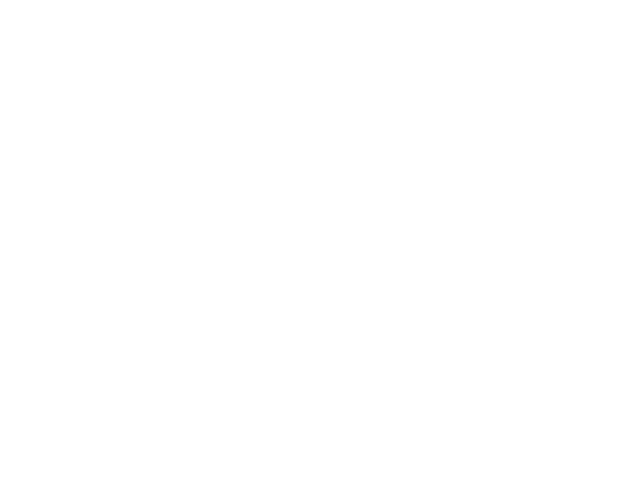

<IPython.core.display.Javascript object>


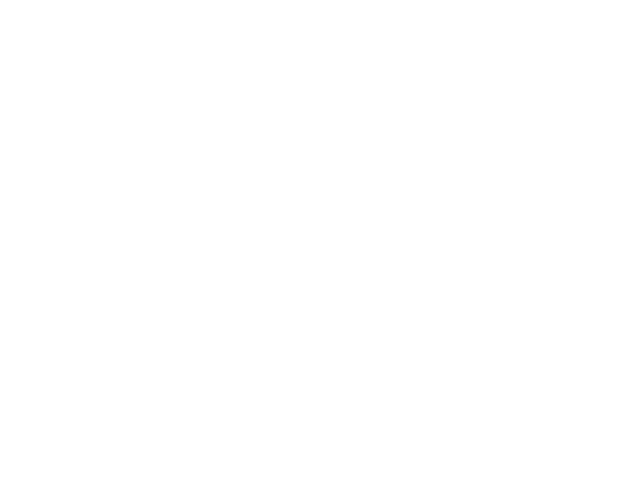

<IPython.core.display.Javascript object>


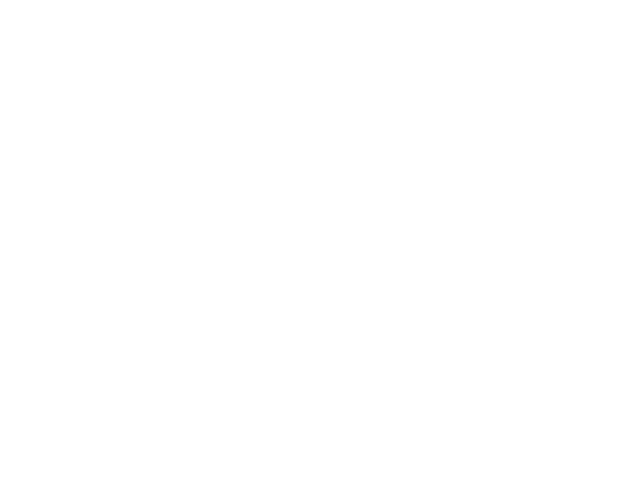

<IPython.core.display.Javascript object>


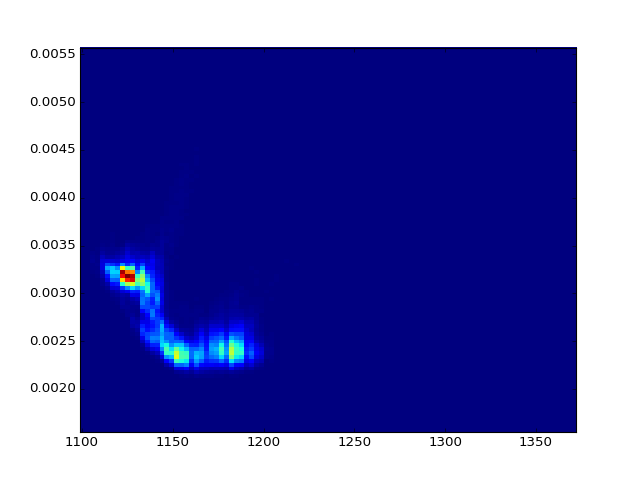

In [15]:
r0, r1 = 0, None
c0, c1 = 0, None


## VIS HI-RES RGB
wm = nnn.watermask()[1]
wm[np.isfinite(hires[0])] = 64

if cut:
    wm = wm[:cutsize, :cutsize]

wm_crp = wm[r0:r1, c0:c1]
hires_rgb_crp = np.array(hires_rgb)[:, r0:r1, c0:c1]

f = Figure([hires_rgb_crp[2], hires_rgb_crp[],hires_rgb_crp[1]],
            mask_array=wm_crp,
            mask_lut={1:[220,220,220], 2:[128,128,128]},
            ratio=0.99)
clim = f.clim_from_histogram()
f.process(cmin=clim[0], cmax=clim[1])
f.save('rgb_hires.png')

## VIS LO-RES RGB
wm = nnn.watermask()[1]
wm[~negpix] = 64

if cut:
    wm = wm[:cutsize, :cutsize]

wm_crp = wm[r0:r1, c0:c1]
lores_rgb_crp = np.array(lores_rgb)[:, r0:r1, c0:c1]

f = Figure(lores_rgb_crp,
            mask_array=wm_crp,
            mask_lut={1:[220,220,220], 2:[128,128,128]},
            ratio=0.99)
f.process(cmin=clim[0], cmax=clim[1] )
f.save('rgb_lores.png')

## VIS scatter plot comparison

vmax = [0.0007, 0.0035, 0.0045]

for rgbi in range(3):
    gpi = np.isfinite(lores_rgb[rgbi]) * np.isfinite(hires_rgb[rgbi])
    r = np.corrcoef([lores_rgb[rgbi][gpi], hires_rgb[rgbi][gpi]])[1,0]
    plt.hist2d(lores_rgb[rgbi][gpi], hires_rgb[rgbi][gpi], 100,
               range=[[0, vmax[rgbi]], [0, vmax[rgbi]]], norm=LogNorm())
    plt.colorbar(shrink=0.8)
    plt.title('R=%f' % r)
    plt.xlabel('$R_{rsMODIS}, sr^{-1}$')
    plt.ylabel('$R_{rsFUSED}, sr^{-1}$')
    plt.savefig(pref + 'hist2d_%02d.png' % rgbi, bbox_inches='tight', pad_inches=0)
    plt.close()

gpi = np.isfinite(lores_rgb[0]) * np.isfinite(hires_rgb[0])
plt.hist2d(lores_rgb[0][gpi], hires_rgb[0][gpi], 100);plt.show()

plt.hist2d(hires[0][gpi], hires_rgb[2][gpi], 100);plt.show()


#plt.hist2d(lores_rgb[0][gpi], hires_rgb_tmp[0][gpi], 1000, range=[[0, 0.02], [0, 0.02]]);plt.show()

#plt.hist2d(lores_rgb[1][gpi], hires_rgb[1][gpi], 1000, range=[[0, 0.02], [0, 0.02]]);plt.show()
#plt.hist2d(lores_rgb[2][gpi], hires_rgb[2][gpi], 1000, range=[[0, 0.02], [0, 0.02]]);plt.show()
#plt.hist2d(lores_rgb[2][gpi], hires[0][gpi], 1000);plt.show()

#hrgf = [gaussian_filter(hrrgb, 2) for hrrgb in hires_rgb]
#f = Figure(hrgf)
#f.process(cmin=clim[0], cmax=clim[1])
#f.save(pref + mfile + '_rgb_hires_gf.png')

In [33]:
n_modisa = Nansat('output/')
plt.figure()
plt.imshow(n_modisa['Rrs_555'])
plt.colorbar()
plt.show()

12:46:54|40|nansat|_get_mapper|GDAL could not open output/, trying to read with Nansat mappers...
ERROR:Nansat:GDAL could not open output/, trying to read with Nansat mappers...


IOError: output/: File does not exist

In [9]:
n_sentinel = Nansat('output/S2A_OPER_PRD_MSIL1C_PDMC_20160904T205606_R126_V20160903T164322_20160903T164911.SAFE_full.nc')
n_sentinel